# Markov Random Geometric Graph (MRGG):
# A Growth Model for Temporal Dynamic Networks

In [1]:
from MRGG.Graph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import os

# 1) Basic applications of the algorithm on simulated data

#### We use the envelope and the latutide functions presented in Eq.(10) of the paper. We build a graph with $1500$ nodes and we run the algorithm SCCHEi. We select the dimension of our model using the slope heuristic. The figure below presents the evolution $\tilde R(\kappa)$ (as defined in Eq.(6)) with respect to $\kappa$. 

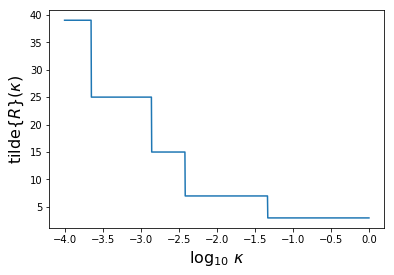

In [3]:
np.random.seed(2)
n = 1500
dimension = 3
G = Graph(n,dimension, sampling_type='markov',envelope='heaviside',latitude='mixture', sparsity = 1)
G.SCCHEi_with_R_search(listeR=[i for i in range(1,20)], figure=True)

### Visualization of the envelope and latitude functions (see figures provided in Section 1 of the paper)

##### Envelope function

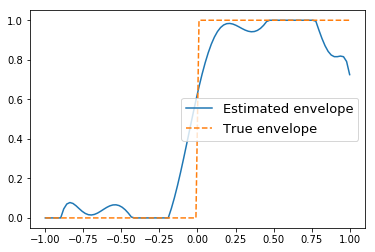

In [4]:
G.plot_estimation_envelope(savename='env-mix-hea.png')

##### Latitude function

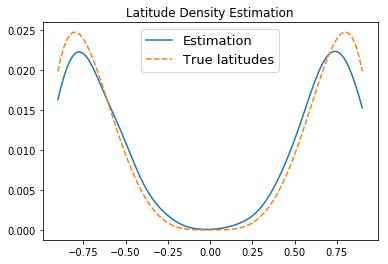

In [5]:
G.plot_densities_latitude(savename='lat-mix-hea.png')

### Clustering of the eigenvalues of the adjacency matrix

We plot the eigenvalues of the adjacency matrix of the graph with colors corresponding to clusters built by our algorithm SCCHEi.

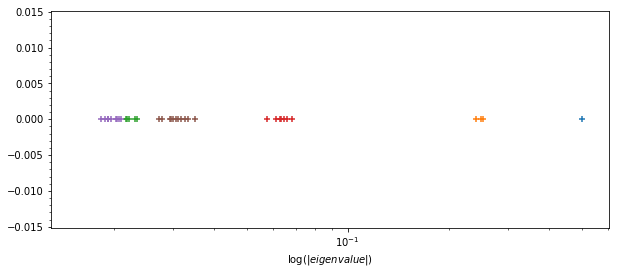

In [6]:
G.plot_eigenvalues_clusters_labeled(5)

In the following figure, we plot the eigenvalues $(p^*_k)_{k \geq 0}$ of the true envelope function $p$ and $(\hat{p}_k)_{k \geq 0}$ of the estimated envelope function (without multiplicity).

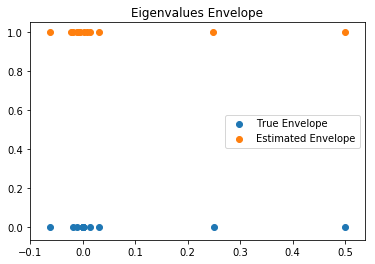

In [7]:
G.plot_comparison_eig_envelope()

In the following, we plot the eigenvalues of the adjacency matrix sorted in decreasing order of magnitude with blue crosses, while red diamonds present the spectrum $(\hat{p}_k)_{k \geq 0}$ (plotted with multiplicity) built using the algorithm SCCHEi.

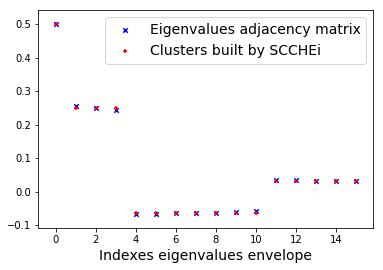

In [8]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(3)

# 2) Studying the performance of the algorithm with a size increasing

### /!\ You may need a cluster to launch the following script.

In [ ]:
def study_error(latitude,enveloppe):
    d = 3
    results  = {'error_enveloppe':[],'error_latitude':[],'size':[]}
    listen = list(map(int,np.logspace(np.log10(20),np.log10(1000),20)))
    for n in listen:
        for _ in range(7):
            G = Graph(n, d, sampling_type = 'markov', latitude = latitude, enveloppe = enveloppe)
            G.SCCHEi_with_R_search()
            results['error_enveloppe'].append(G.error_estimation_enveloppe())
            results['error_latitude'].append(G.error_estimation_latitude())
            results['size'].append(n)
    df = pd.DataFrame(results)
    df = df.apply(np.log10)
    return df

import seaborn as sns
def plot_errors(dataframe):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=dataframe, ax = ax, label='Envelope')
    ax.set_xlabel('$\log \;n$', fontsize=16)
    ax.set_ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=16)
    ax.set_title('Estimation Error Envelope function', fontsize=16)
    plt.legend(fontsize=16)
    ax = fig.add_subplot(122)
    c = sns.lineplot(x="size", y="error_latitude", err_style="bars", data=dataframe, ax = ax, label='Latitude')
    c.lines[0].set_linestyle("--")
    ax.set_xlabel('$\log \; n$', fontsize=16)
    ax.set_ylabel('$\log \; \delta_2(f^*,\hat{f})$', fontsize=16)
    ax.set_title('Estimation Error Latitude function', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

In [ ]:
import pickle
df = study_error('mixture', 'heaviside')
plot_errors(df)

# 3) Application on real data : Facebook messages dataset (see Section 5)
 

###### We use the data located at  http://networkrepository.com/fb-messages.php

In [9]:
# Extracting messages with timestamps
filepath = 'data/'
with open(filepath+'fb-messages.edges') as f:
    content = f.readlines()
    data = []
    for line in content:
        L = line.split(',')
        L = [int(L[0]),int(L[1]),np.float(L[2][:-1])]
        data.append(L)
data = np.array(data)

# Building connections between students
M = np.max(data[:,0])
m = np.min(data[:,0])
M1 = np.max(data[:,1])
m1 = np.min(data[:,1])
M = max(M,M1)
m = min(m,m1)
M = int(M)
m = int(m)
A = np.zeros((M,M))
order = np.argsort(data[:,2])
data = data[order,:]
timestamps = {}
for k in range(data.shape[0]):
    i = int(data[k,0]-1)
    j = int(data[k,1]-1)
    A[i,j], A[j,i] = 1,1
    timestamps[(i,j)] = data[k,2]
    timestamps[(j,i)] = data[k,2]
    
# Self avoiding random walk
IDS = []
seen = np.zeros(M)
state = 0
count = 0
IDS.append(state)
listes = []
newliste = [state]
np.random.seed(1)
while count<A.shape[0]:
    L = np.where(A[state,:]==1)[0]
    notseen = np.where(seen==0)[0]
    L = list(set(list(L)) & set(list(notseen)))
    if L == []:
        listes.append(newliste)
        state = np.random.choice(notseen)
        newliste = [state]
    else:
        ind = np.argmin([timestamps[(state,j)] for j in L])
        state = L[ind]
        newliste.append(state)
    seen[state] = 1
    IDS.append(state)
    count += 1
    
# Keeping excursions of length at least 10
IDS = []
for i in range(len(listes)):
    if len(listes[i])>=20:
        IDS += listes[i]
        
# Building the adjancency matrix of the graph
B = A[:,IDS]
B = B[IDS,:]

##### We launch SCCHEI algorithm on our real dataset and we use the slope heurisitc to select the model dimension $\tilde R$. The figure below show the evolution of $\tilde R(\kappa)$ with respect to $\kappa$.

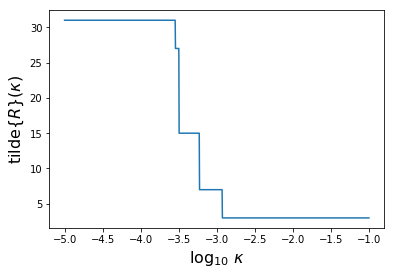

In [10]:
G = Graph(B.shape[0],3,adjacency_matrix=B)
listekappa = np.logspace(-5,-1,1000)
G.SCCHEi_with_R_search(listekappa=listekappa, figure=True)

### Code to reproduce exactly the figure shown in Section D of the Supplementary Material

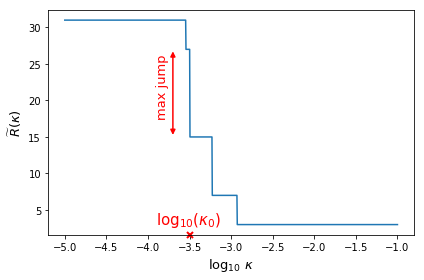

In [11]:
listekappa=np.logspace(-5,-1,1000)
listeR =None
G.compute_dimensions_sphere()
L = len(G.dimensions)
if listeR is None:
    listeR = [i for i in range(1,L)]
if listekappa is None:
    listekappa = np.logspace(-4,0,1000)
listeI = []
listeSpectra = []
for R in listeR:
    I, spectrumenv = G.SCCHEi(R)
    listeI.append(I)
    listeSpectra.append(spectrumenv)

listeI = np.array(listeI)
M = np.tile(listekappa.reshape(1,-1),(len(listeR),1))
M /= G.n
dims = np.array(G.dimensions)[listeR]
M *= np.tile(dims.reshape(-1,1),(1,len(listekappa)))
M += np.tile(listeI.reshape(-1,1),(1,len(listekappa)))
R_kappa = np.argmin(M, axis=0)
D_kappa = dims[R_kappa]
gap = -np.float('inf')
kappa0 = 0
bestI = 0
for i in range(len(listekappa)-1):
    newgap = D_kappa[i] - D_kappa[i+1]
    if newgap > gap:
        gap = newgap
        kappa0 = listekappa[i]
        bestI = i

crit = np.float('inf')
for i,R in enumerate(listeR):
    nextcrit = listeI[i] + 2*kappa0*dims[i]/G.n
    if crit > nextcrit:
        G.spectrumenv = listeSpectra[i]
        crit = nextcrit
from matplotlib.transforms import BlendedGenericTransform
if True:
    fig, ax = plt.subplots()
    ax.plot(np.log10(listekappa), D_kappa)
    ax.plot(np.log10(listekappa[bestI]), np.zeros_like(np.log10(listekappa[bestI])), 'rx', clip_on=False, mew=2, transform=BlendedGenericTransform(ax.transData, ax.transAxes))
    limits = np.array(ax.axis())
    ax.axis(limits)
    ax.text(-3.9,3, '$\log_{10}(\kappa_0)$',color='red', fontsize=15)
    ax.annotate('', xy=(-3.7, 27),
             xycoords='data',
             xytext=(-3.7, 15),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='red',
                             lw=1.5,
                             ls='-')
           )
    ax.text(-3.9, 25, 'max jump', 
         rotation = 90, color='red', fontsize = 13)
    ax.set_xlabel('$\log_{10}$ $\kappa$', fontsize=13)
    ax.set_ylabel('$\\widetilde{R}(\kappa)$', fontsize=13)
    plt.tight_layout()
    plt.savefig('slope-heuristic.png',dpi=300)

### Estimated envelope

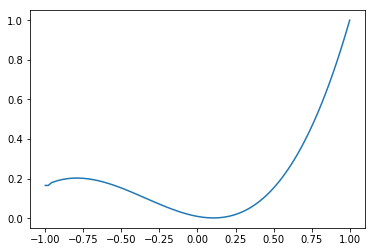

In [12]:
G.plot_estimation_envelope_real_data(savename='email-slope-envelope.png')

### Estimated Latitude function

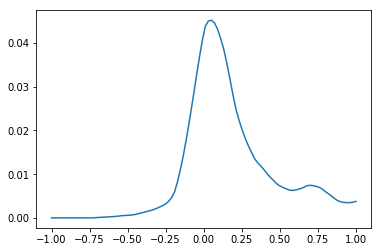

In [13]:
G.plot_density_latitude_real_data(percent=0.1,savename='email-slope-latitude.png')

# 4) Application on real data : Gowalla dataset (see Section F)


###### You can download the data at  https://snap.stanford.edu/data/loc-gowalla.html
###### You should  save the files from the above links in the folder 'data'.

In [ ]:
edges = []
with open('data/Gowalla_edges.txt') as f:
    content = f.readlines()
    fist = True
    for line in content:
        l = line.split('\t')
        edges.append([int(l[0]),int(l[1][:-1])])
edges = np.array(edges)

import datetime as date
   
checkin = []
with open('data/Gowalla_totalCheckins.txt') as f:
    content = f.readlines()
    for line in content:
        l = line.split('\t')[:2]
        timeformat = date.datetime.strptime(l[1][:-1],"%Y-%m-%dT%H:%M:%S")
        li = [int(l[0]),date.datetime.timestamp(timeformat)]
        checkin.append(li)

checkin = np.array(checkin)
checkin = checkin[np.argsort(checkin[:,1]),:]

order = []
ID = -1
for i in range(checkin.shape[0]):
    if checkin[i,0] != ID:
        order.append(checkin[i,0])
name2ID = {}
ID2name = {}
count = 0
for k in range(len(order)):
    if order[k] not in name2ID.keys():
        name2ID[order[k]] = count
        ID2name[count] = order[k]
        count += 1
n = len(name2ID)
rows = []
cols = []
data = []
for k in range(edges.shape[0]):
    try:
        i,j = name2ID[edges[k,0]], name2ID[edges[k,1]]
        rows.append(i)
        rows.append(j)
        cols.append(j)
        cols.append(i)
        data.append(1.0)
        data.append(1.0)
    except:
        pass

In [ ]:
A = sc.sparse.coo_matrix((data, (rows, cols)))
nbeigvals = 100
eig, vec = sc.sparse.linalg.eigsh(A, k=nbeigvals, which='LA')
dimension = 2
G = Graph(2*nbeigvals,dimension)
G.dec_eigs = eig[::-1]
G.SCCHEi_with_R_search()

###### Clustering eigenvalues

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(2)

###### Envelope function

In [ ]:
x = np.linspace(-1,1,100)
G.esti = [G.estimation_enveloppe(xi)  for xi in x]
M = np.max(G.esti)
G.esti /= M
G.esti = list(map(lambda x:max(0,x),G.esti))
plt.plot(x, G.esti)
plt.title('Estimated envelope function')

###### Latitude function

In [ ]:
order = np.argsort(eig)[::-1]
V = vec[:,order[1:3]]
updiag = (V.shape[0] /G.d) * np.array([np.dot(V[i,:],V[i+1,:]) for i in range(V.shape[0]-1)])

from sklearn.neighbors import KernelDensity
L = updiag 
percent = 0.05
Labs = np.sort(np.abs(updiag))
size = percent * len(updiag)
normalize = Labs[int(size)]
L /= normalize
L = np.array(list(map(lambda x : min(max(-1,x),x),L))).reshape(-1,1)

kde = KernelDensity(kernel='linear', bandwidth=0.3).fit(L.reshape(-1,1))
x = np.linspace(-1,1,100)
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens)/sum(np.exp(log_dens)))
plt.title('Estimated latitude function')